In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from imv_lstm import IMVFullLSTM
from descriptors import descriptors

In [2]:
# Load and process data
def load_dataset():
	Y = []
	X = []
	
	for location in ["icu-mortality-data/", "icu-mortality-data-b/", "icu-mortality-data-c/"]:
		with open(location + "outcomes.csv", "r") as y_file:
			next(y_file)
			for line in y_file:
				y_values = line.split(',')
				x_name, fatality = y_values[0], int(y_values[5])

				Y.append(fatality)
				X_example = torch.zeros((48, len(descriptors)))
				with open(location + x_name + ".txt", "r") as x_file:
					next(x_file)
					next(x_file)

					for line2 in x_file:
						try:
							x_values = line2.split(',')
							hour = int(x_values[0][1])
							descriptor = x_values[1]
							value = float(x_values[2].strip('\n'))

							X_example[hour][descriptors.index(descriptor)] = value
						except ValueError:
							# Invalid descriptor
							continue
				X.append(X_example)
	return torch.stack(X), torch.FloatTensor(Y)

def test_model_accuracy(X, Y):
    # torch.cuda.empty_cache()
    X = X.cuda()
    Y = Y.cuda()
    
    with torch.no_grad():
        output, a, b = model(X)
        
    output = output.detach()
    output_thresholded = torch.sigmoid(output) >= 0.5
    Y_1 = torch.unsqueeze(Y, dim=1).bool()

    TP = torch.count_nonzero(torch.bitwise_and(output_thresholded, Y_1))
    TN = torch.count_nonzero(torch.bitwise_and(torch.bitwise_not(output_thresholded), torch.bitwise_not(Y_1)))

    FP = torch.count_nonzero(torch.bitwise_and(output_thresholded, torch.bitwise_not(Y_1)))
    FN = torch.count_nonzero(torch.bitwise_and(torch.bitwise_not(output_thresholded), Y_1))

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    score1 = torch.min(precision, recall)

    z = torch.count_nonzero(Y == output_thresholded)
    acc = z / output_thresholded.shape[0]
    acc = (TP + TN) / (TP + TN + FP + FN)
    
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Score1: {score1}")
    print(f"Accuracy: {acc}")

    return precision, recall, score1, acc

X, Y = load_dataset()

In [3]:
# Split data into respective groups
torch.cuda.empty_cache()
split_percentage = 2/3
bound = int(X.shape[0]*split_percentage)
print(bound)

X_train, Y_train = X[0:bound], Y[0:bound]
X_test, Y_test = X[bound:X.shape[0]], Y[bound:X.shape[0]]
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=64, shuffle=True)

# Define model
device = torch.device("cuda")
model = IMVFullLSTM(device, X.shape[2], 1, 128).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss = nn.BCEWithLogitsLoss()
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

# Optional: Load checkpoint
model.load_state_dict(torch.load("out/model_weights_0.66S_22E_S_D.pt", map_location=device))

8000


<All keys matched successfully>

In [ ]:
# Perform training
epochs = 25
for i in range(epochs):
    model.train()
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    print("Epoch " + str(i) + " complete, loss: " + str(l.item()))
    model.eval()
    _, recall, _, _ = test_model_accuracy(X_test[0:2000], Y_test[0:2000])
    if recall >= 0.4:
        print("Saving special weights...")
        torch.save(model.state_dict(), f"out/model_weights_0.66S_{i}E_S_D.pt")
    epoch_scheduler.step()
    
# print("Saving...")
# torch.save(model.state_dict(), f"out/model_weights.pt")

In [5]:
# Test model accuracy
model.eval()

print("Test")
test_model_accuracy(X_test[0:2000], Y_test[0:2000])
# print("Train a")
# test_model_accuracy(X_train[0:4000], Y_train[0:4000])
# print("Train b")
# test_model_accuracy(X_train[4000:8000], Y_train[4000:8000])

Test
Precision: 0.5708154439926147
Recall: 0.43322476744651794
Score1: 0.43322476744651794
Accuracy: 0.8629999756813049


(tensor(0.5708, device='cuda:0'),
 tensor(0.4332, device='cuda:0'),
 tensor(0.4332, device='cuda:0'),
 tensor(0.8630, device='cuda:0'))

In [7]:
# Reload model using the CPU
device = torch.device("cpu")
model = IMVFullLSTM(device, X.shape[2], 1, 128).to(device)
model.eval()
model.load_state_dict(torch.load("out/model_weights_0.66S_22E_S_D.pt", map_location=device))

<All keys matched successfully>

In [10]:
# Perform CPU Inference
index = 97
test_x = torch.unsqueeze(X_test[index], dim=0)
with torch.no_grad():
    output, a, b = model(test_x)
    
output = output.detach()
print(output)
print(torch.sigmoid(output))
print(Y_test[index])
# print(test_x[0, :, descriptors.index("HR")])

a = torch.squeeze(a).cpu().T
b = torch.squeeze(b).cpu()

tensor([[-0.5089]])
tensor([[0.3755]])
tensor(0.)


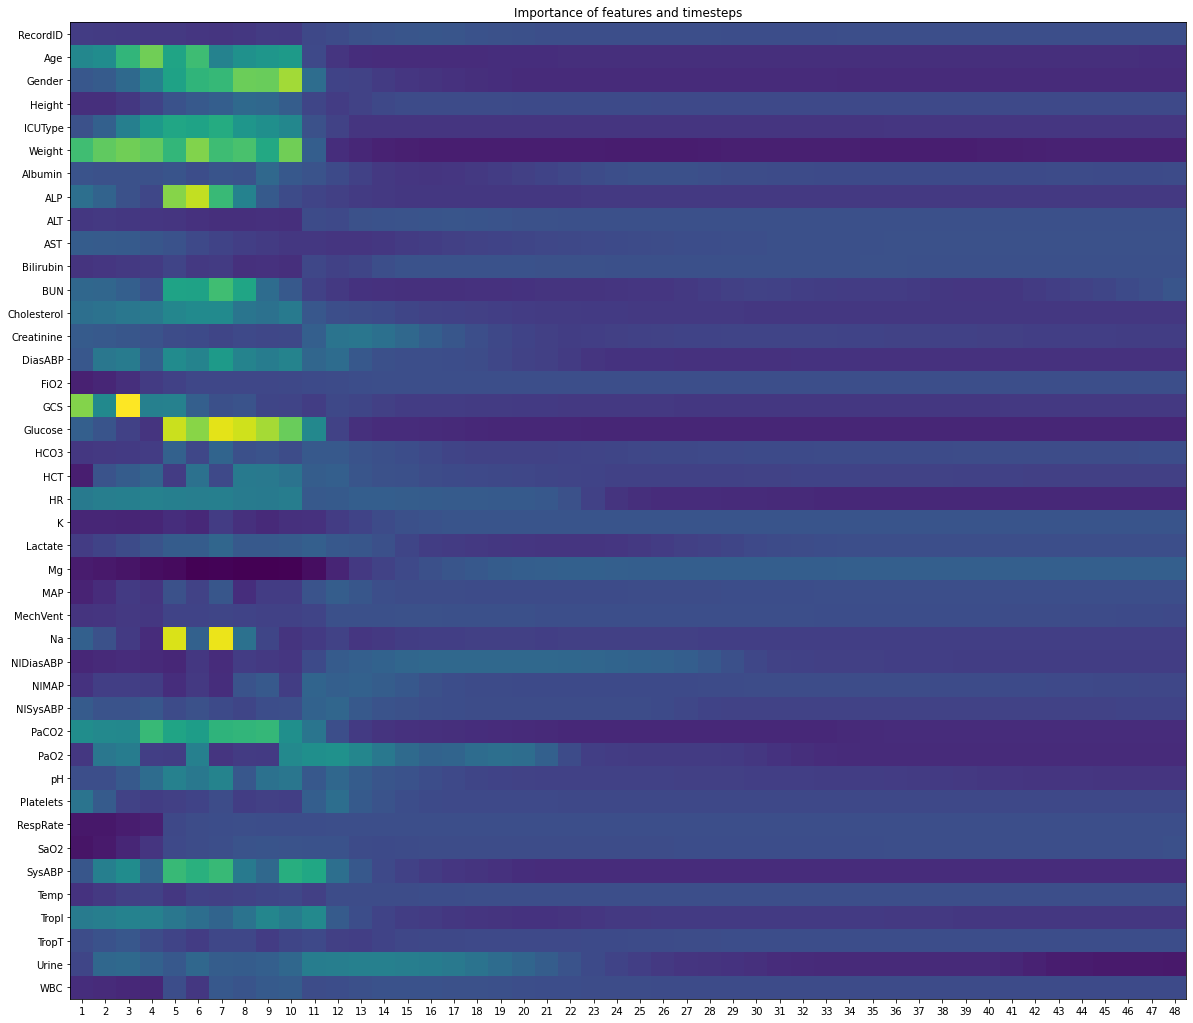

In [11]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(a)
ax.set_xticks(torch.arange(test_x.shape[1]))
ax.set_yticks(torch.arange(len(descriptors)))
ax.set_xticklabels([i.item() for i in torch.arange(1, test_x.shape[1]+1)])
ax.set_yticklabels(descriptors)
ax.set_title("Importance of features and timesteps")
plt.show()

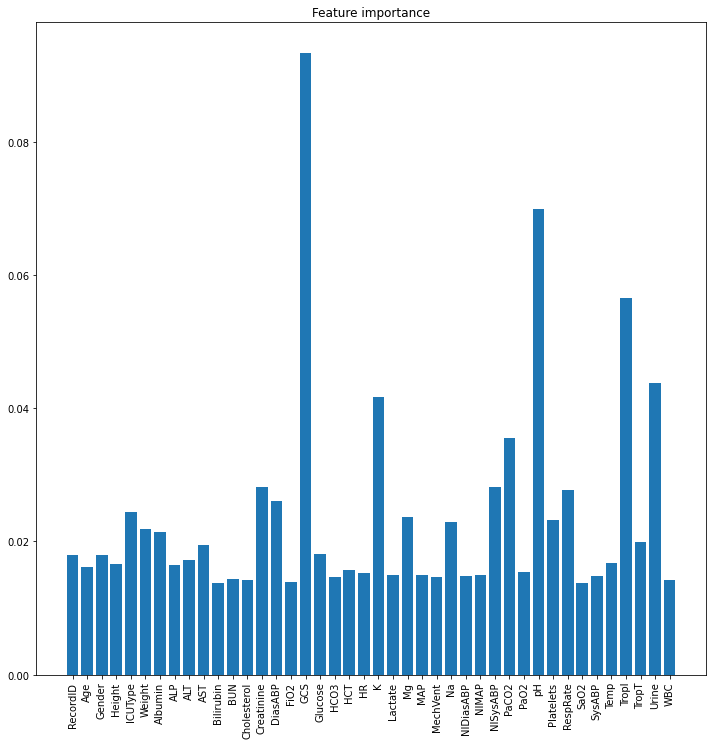

In [12]:
plt.figure(figsize=(12, 12))
plt.title("Feature importance")
plt.bar(range(len(descriptors)), b)
plt.xticks(ticks=range(len(descriptors)), labels=descriptors, rotation=90)
plt.show()